# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [54]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of gan.losses failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 374, in superreload
    module = reload(module)
  File "/usr/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 669, in exec_module
  File "<frozen importlib._bootstrap_external>", line 775, in get_code
  File "<frozen importlib._bootstrap_external>", line 735, in source_to_code
  File "<frozen importlib._bootstrap>", line 222, in _call_with_frames_removed
  File "/home/jkane021/gan/gan/losses.py", line 36
    return loss
         ^
SyntaxError: i

In [55]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


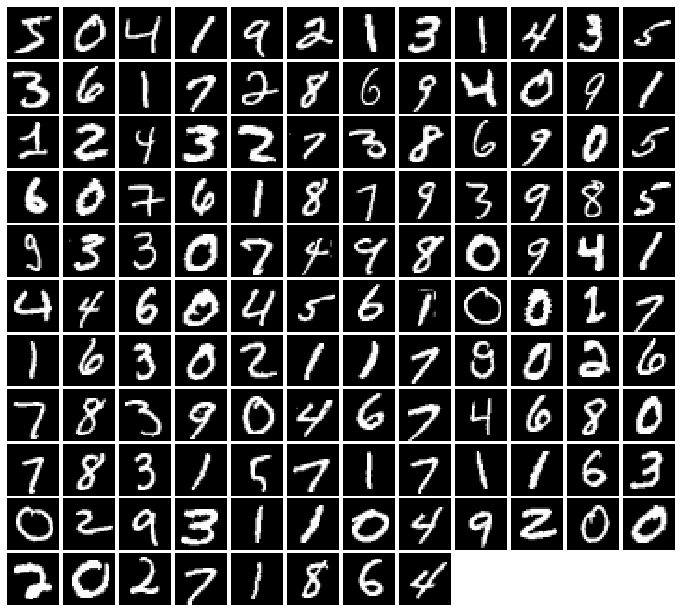

In [57]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [58]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [59]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [60]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.365, G:0.7213


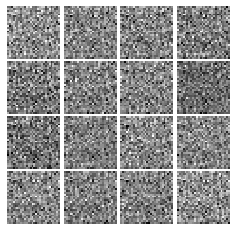


Iter: 250, D: 1.16, G:1.068


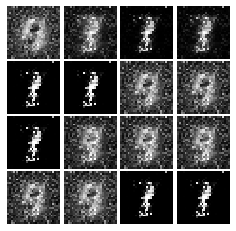


EPOCH:  2
Iter: 500, D: 0.923, G:1.2


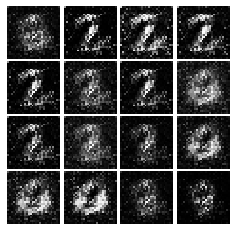


Iter: 750, D: 0.8568, G:1.658


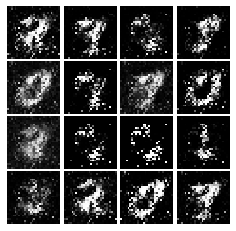


EPOCH:  3
Iter: 1000, D: 1.013, G:1.583


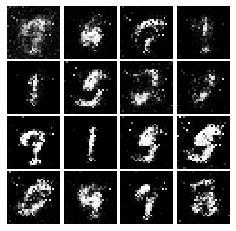


Iter: 1250, D: 1.352, G:1.0


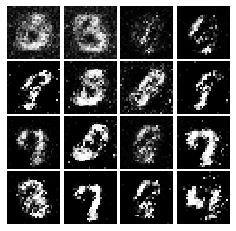


EPOCH:  4
Iter: 1500, D: 1.23, G:0.8353


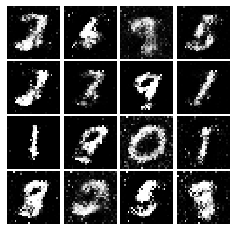


Iter: 1750, D: 1.572, G:0.5593


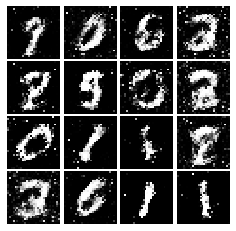


EPOCH:  5
Iter: 2000, D: 1.243, G:0.9355


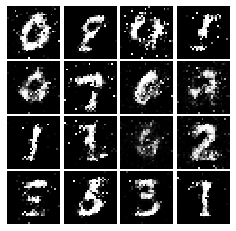


Iter: 2250, D: 1.07, G:0.6851


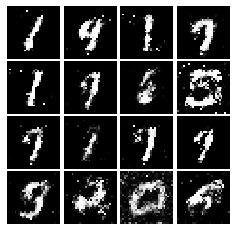


EPOCH:  6
Iter: 2500, D: 1.315, G:0.8746


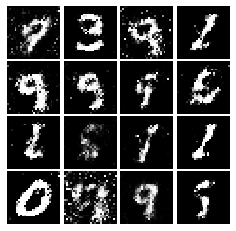


Iter: 2750, D: 1.383, G:0.8531


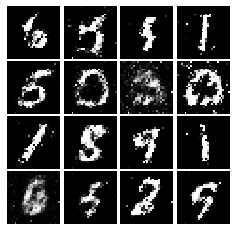


EPOCH:  7
Iter: 3000, D: 1.272, G:1.014


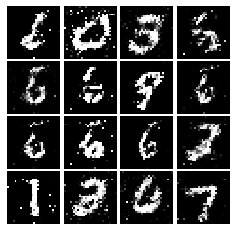


Iter: 3250, D: 1.145, G:0.9262


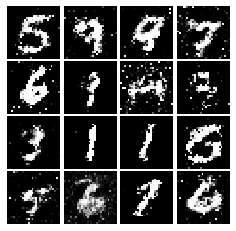


EPOCH:  8
Iter: 3500, D: 1.256, G:0.905


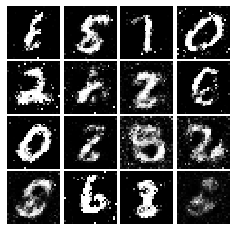


EPOCH:  9
Iter: 3750, D: 1.349, G:0.8866


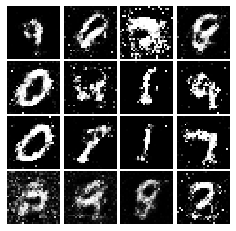


Iter: 4000, D: 1.377, G:0.7097


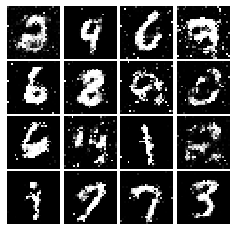


EPOCH:  10
Iter: 4250, D: 1.202, G:0.9483


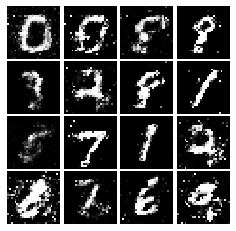


Iter: 4500, D: 1.356, G:0.8379


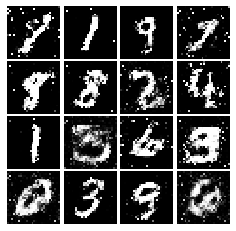

In [61]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5049, G:0.5233


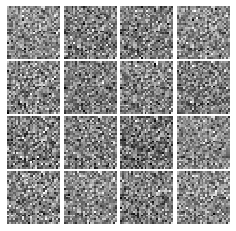


Iter: 250, D: 0.05888, G:0.3942


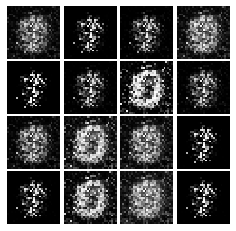


EPOCH:  2
Iter: 500, D: 0.1051, G:0.5203


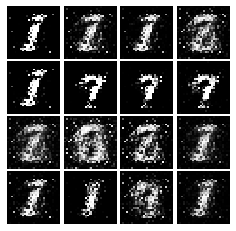


Iter: 750, D: 0.1389, G:0.3259


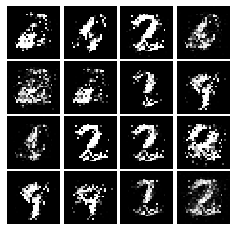


EPOCH:  3
Iter: 1000, D: 0.1624, G:0.2668


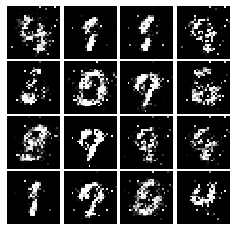

KeyboardInterrupt: 

In [63]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)